## Локальный и глобальный поиск

Решите задачу коммивояжера на основе файла данных `hw9_data/tsp.csv`: найти минимальный НЕЦИКЛИЧЕСКИЙ путь (начинается и заканчивается в разных точках), соединяющий N точек. Файл содержит координаты каждого из городов на плоскости. Используйте L1 расстояние для расчетов и визуализации.

In [1]:
# реализуем класс для задачи коммивояжера
import numpy as np
from numpy.random import choice

class traveling_salesmans_task():
    def __init__(self, sity_coodinates, permutation=None):
        if type(sity_coodinates) == str:
            self.x, self.y = self._init_coordinates(sity_coodinates)
        else:
            self.x, self.y = sity_coodinates
            
        self.permutation = np.arange(len(self.x)) if permutation is None else permutation
    
    def set_permutation(self, new_permutation):
        self.permutation = new_permutation
    
    def comute_l1_loss(self, permutation=None):
        permutation = self.permutation if permutation is None else permutation

        L1_loss = sum(abs(np.diff(self.x[permutation])))
        L1_loss += sum(abs(np.diff(self.y[permutation])))
        
        return L1_loss
    
    @staticmethod
    def _init_coordinates(path):
        with open(path, "r") as f:
            coordinates = np.array(list(map(lambda x: x.split(','), f.read().split())))

        return coordinates[:, 1].astype("float"), coordinates[:, 2].astype("float")
    
def change_permutataion(permutation, n_changes=4):
    changed_samples = choice(len(permutation), n_changes, replace=False)
    new_permutation = permutation.copy()
    new_permutation[changed_samples] = new_permutation[np.roll(changed_samples, 1)]
    
    return new_permutation

In [2]:
tst = traveling_salesmans_task("./hw9_data/tsp.csv")
tst.comute_l1_loss()

27815.0

In [3]:
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import matplotlib.pyplot as plt


def get_l1_path(tst, permutation):
    nodes_x, nodes_y = tst.x[permutation], tst.y[permutation]
    x0, y0 = nodes_x[0], nodes_y[0]
    
    verts = [(x0, y0)]
    for x, y in zip(nodes_x[1:], nodes_y[1:]):
        verts.append((x, y0))
        verts.append((x, y))
        x0, y0 = x, y
        
    return verts

def plot_path(tst, permutation):
    codes = [Path.MOVETO] + [Path.LINETO]*2*(len(permutation)-1) 
    vertices = get_l1_path(tst, permutation)

    vertices = np.array(vertices, float)
    line_path = Path(vertices, codes)

    pathpatch = PathPatch(line_path, facecolor='None', edgecolor='blue')

    fig, ax = plt.subplots(figsize=(15,15))
    ax.add_patch(pathpatch)
    ax.autoscale_view()
    ax.scatter(tst.x, tst.y)
    
    plt.title(f'Best path with distance: {tst.comute_l1_loss(permutation)}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

### Задание 1 (1 балл) 

Реализуйте Монте-Карло поиск.

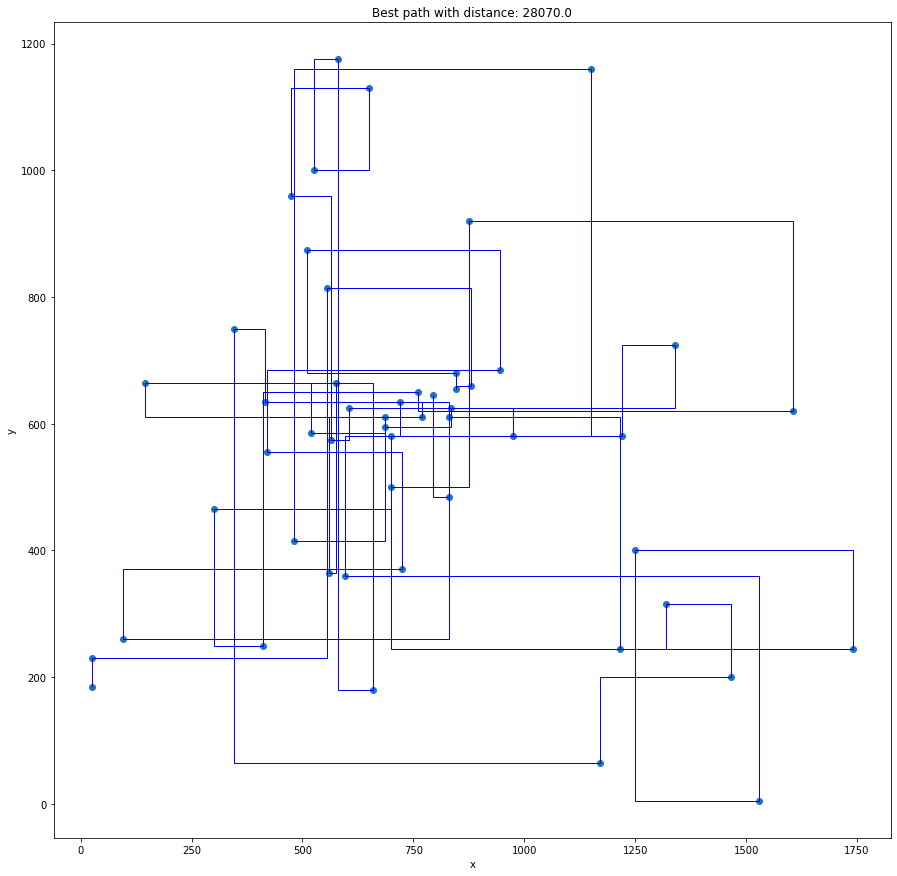

In [4]:
def Monte_Carlo(tst, iters): # тут я не сохраняю лучшую перестановку
    best_loss = np.inf
    
    for _ in range(iters):
        permutation = np.random.permutation(len(tst.x))
        loss = tst.comute_l1_loss(permutation)

        if loss < best_loss:
            best_loss = loss
            best_permutation = permutation.copy()
        
    return best_permutation, best_loss

permutation, loss = Monte_Carlo(tst, 100000)
plot_path(tst, permutation)

### Задание 2 (1 балл) 

Реализуйте поиск случайным блужданием.

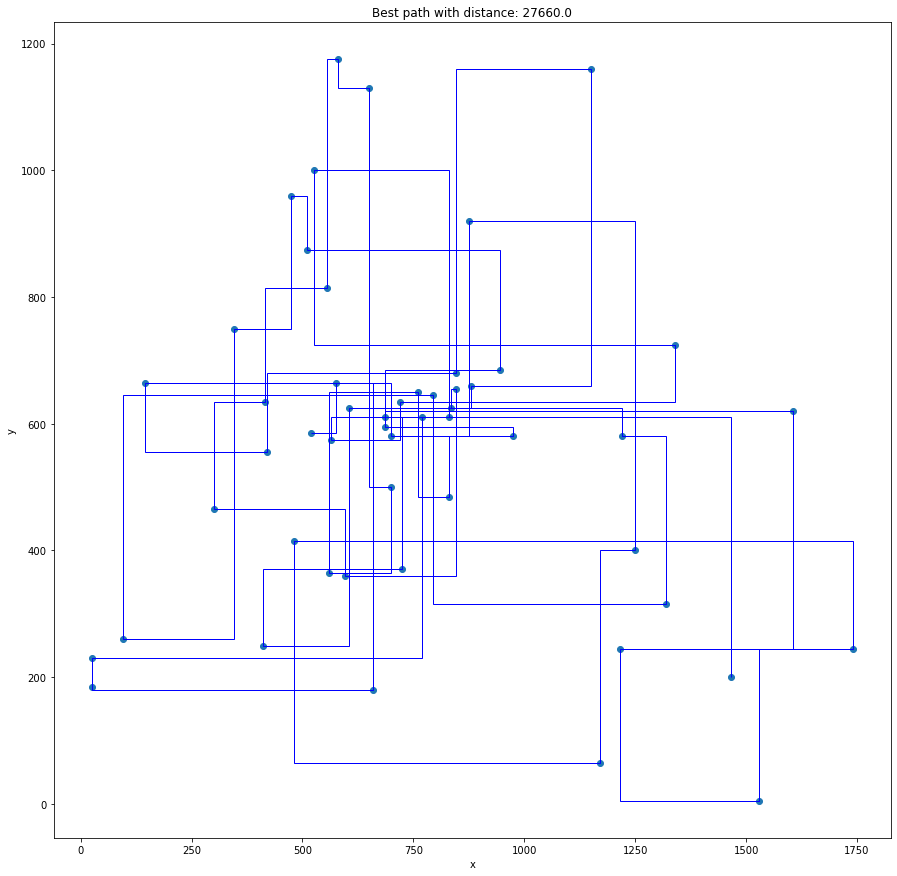

In [5]:
def Random_Walk(tst, iters, n_changing_samples=2):
    best_loss = np.inf
    permutation = np.random.permutation(len(tst.x))

    for _ in range(iters):
        permutation = change_permutataion(permutation, n_changes=n_changing_samples)
        loss = tst.comute_l1_loss(permutation)
        
        if best_loss > loss:
            best_loss = loss
            best_permutation = permutation.copy()
            
    return best_permutation, best_loss


permutation, loss = Random_Walk(tst, 100000, 2)
plot_path(tst, permutation)

### Задание 3 (2 балла) 

Реализуйте Hill Climb.

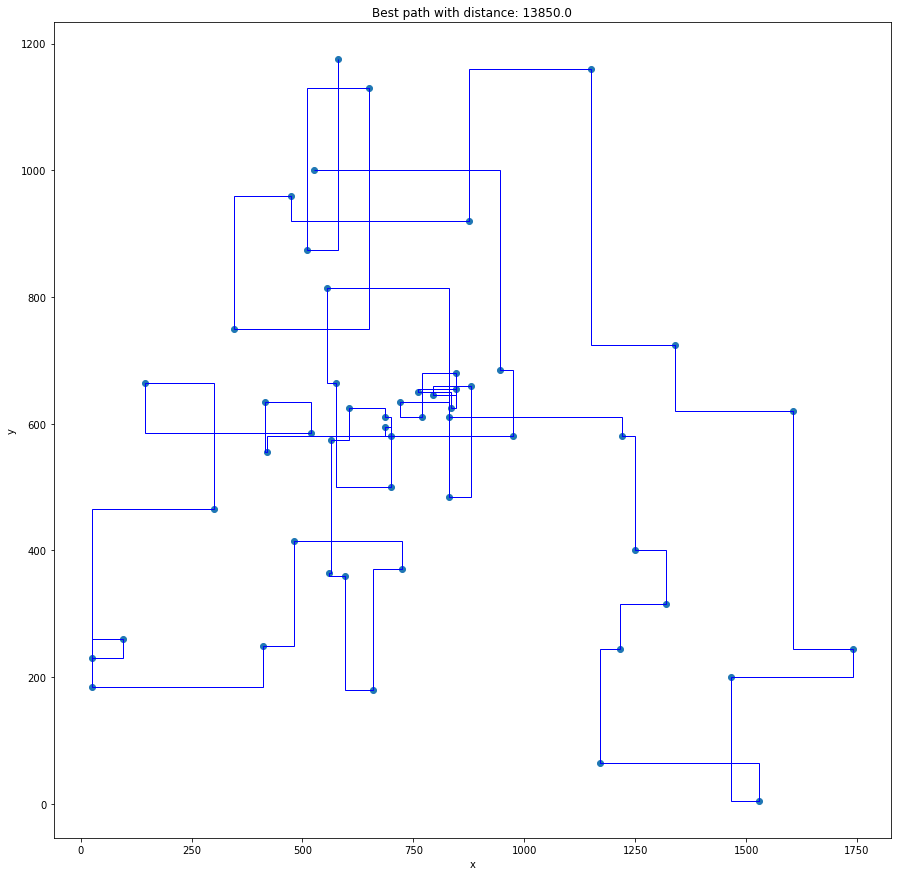

In [6]:
from scipy.special import softmax

def stohastic_hill_climb(tst, n_estimation=10, n_iters=1000, n_changes=2):
    best_permutation = np.random.permutation(len(tst.x))
    
    for _ in range(n_iters):
        permutations = [0] * n_estimation
        losses = np.zeros(n_estimation)
        
        for i in range(n_estimation):
            permutations[i] = change_permutataion(best_permutation, n_changes=n_changes)
            losses[i] = tst.comute_l1_loss(permutations[i])
        
        softmax_losses = softmax(-losses)
        best_permutation = permutations[choice(len(permutations), p=softmax_losses)]
    
    return best_permutation, tst.comute_l1_loss(best_permutation)


permutation, loss = stohastic_hill_climb(tst, n_iters=10000, n_estimation=20, n_changes=2)
plot_path(tst, permutation)

### Задание 4 (3 балла) 


Реализуйте отжиг (simulated annealing). Температурный режим отжига выберите самостоятельно.

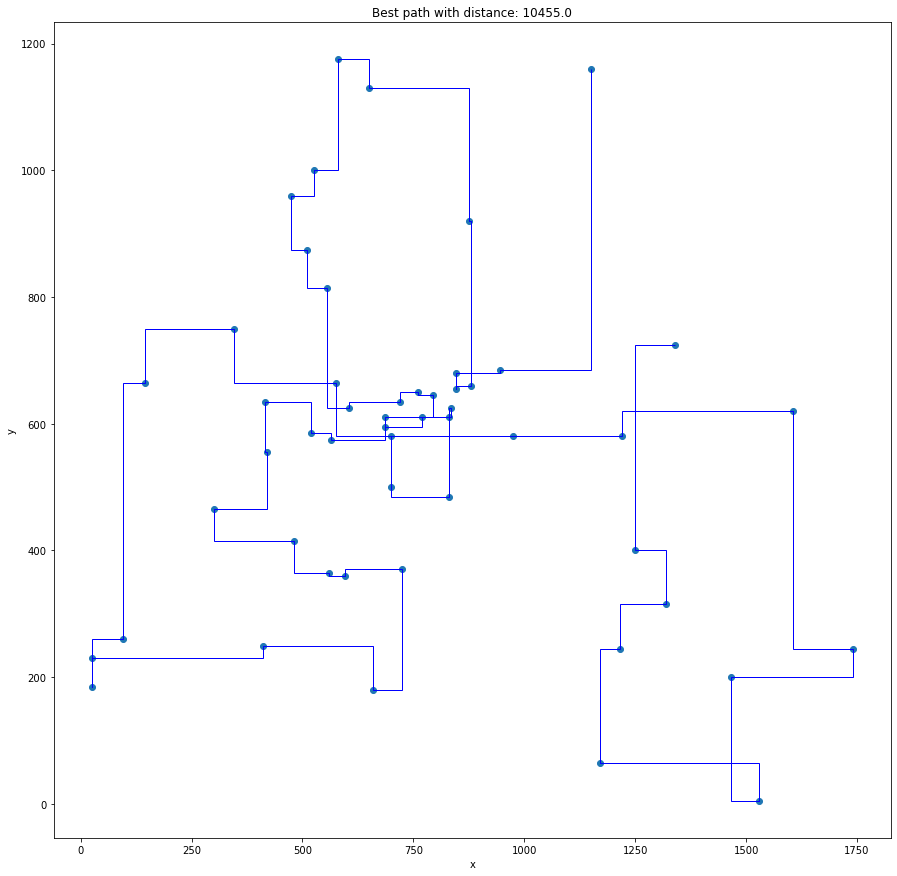

In [7]:
from numpy.random import rand, choice

def simulated_annealing(tst, n_iters, n_changing_samples):

    def temperatures(max_temp=10000, n_iters=n_iters, func=lambda x: x):
        temps = np.linspace(max_temp, 1e-10, n_iters)
        for temp in temps:
            yield func(temp)
     
    old_permutation = np.random.permutation(len(tst.x))
    old_loss = tst.comute_l1_loss(old_permutation)
    
    for temperature in temperatures():
        
        new_permutation = change_permutataion(old_permutation, n_changing_samples)
        new_loss = tst.comute_l1_loss(new_permutation)
        
        if old_loss > new_loss or rand() < np.exp(-(new_loss - old_loss)/temperature):
            old_loss = new_loss
            old_permutation = new_permutation

    
    return old_permutation, old_loss
            

permutation, loss = simulated_annealing(tst, 1000000, n_changing_samples=2)
plot_path(tst, permutation)